In [1]:
# 02_evaluate_bf_diffusion_posterior.py

import sys
import os
import keras
import numpy as np
import bayesflow as bf
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "keras"

# ------------------------------------------------------------------
# Add project paths
# ------------------------------------------------------------------
DATA_PATH = r"C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\src\data"
BF_PATH   = r"C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\src\bf"

sys.path.append(DATA_PATH)
sys.path.append(BF_PATH)

# ------------------------------------------------------------------
# Import your existing scripts
# ------------------------------------------------------------------
from h5_dataset_je_b1_b2 import load_dataset
from data_split import split_dataset
from theta_transform import theta_transform
from noise_model import add_multiplicative_noise

np.random.seed(0)

from make_workflow import make_workflow


# ------------------------------------------------------------------
# 1. Load dataset
# ------------------------------------------------------------------

splits = split_dataset(load_dataset(downsample_to=101), train_frac=0.7, test_frac=0.2, val_frac=0.1, shuffle=True, seed=42)

I_train, theta_condition_train, theta_inference_train = splits[0]
I_test, theta_condition_test, theta_inference_test = splits[1]
I_val, theta_condition_val, theta_inference_val = splits[2]

I_train_clean, theta_tilde_condition, mu_condition, s_condition, theta_tilde_inference, mu_inference, s_inference = theta_transform(splits[0])

x_train, theta_tilde_train_condition, mu_condition, s_condition, theta_tilde_train_inference, mu_inference, s_inference = add_multiplicative_noise(
    (I_train_clean, theta_tilde_condition, mu_condition, s_condition, theta_tilde_inference, mu_inference, s_inference),
    noise_std=0.01,
    seed=123
)

x_test, theta_test_condition, theta_test_inference = add_multiplicative_noise(
    (I_test, theta_condition_test, theta_inference_test),
    noise_std=0.01,
    seed=456
)

theta_tilde_test_condition = (theta_test_condition - mu_condition) / s_condition  # standardize test theta using train mu and s
theta_tilde_test_inference = (theta_test_inference - mu_inference) / s_inference  # standardize test theta using train mu and s

x_val, theta_val_condition, theta_val_inference = add_multiplicative_noise(
    (I_val, theta_condition_val, theta_inference_val),
    noise_std=0.01,
    seed=789
)

theta_tilde_val_condition = (theta_val_condition - mu_condition) / s_condition  # standardize val theta using train mu and s
theta_tilde_val_inference = (theta_val_inference - mu_inference) / s_inference  # standardize val theta using train mu and s

train_dict = {"x": x_train, "theta_condition": theta_tilde_train_condition, "theta_inference": theta_tilde_train_inference}
test_dict = {"x": x_test, "theta_condition": theta_tilde_test_condition, "theta_inference": theta_tilde_test_inference}
val_dict = {"x": x_val, "theta_condition": theta_tilde_val_condition, "theta_inference": theta_tilde_val_inference}


# ------------------------------------------------------------------
# 2. Create diffusion model + workflow
# ------------------------------------------------------------------
diffnet, workflow = make_workflow(
    intrinsic=True,
    widths=(512, 1024, 2048, 2048, 1024, 512, 256),
    time_embedding_dim=128,
    diffusion_steps=1000,
)


# ------------------------------------------------------------------
# 3. Override learning rate (simple control)
# ------------------------------------------------------------------
# workflow.optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# ------------------------------------------------------------------
# 3. Load trained model weights
# ------------------------------------------------------------------
model_path = r"C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\checkpoints\tearfilm_sbi_diffusion_je_b1_b2.keras"
train_after_load = False  # Set to True if you want to continue training after loading the model

if not os.path.exists(model_path):
    print(f"Model file not found at {model_path}. Training a new model...")
    _ = workflow.fit_offline(
        train_dict,
        validation_data=val_dict,
        epochs=20,
        batch_size=256,
        verbose=2,
    )
    workflow.approximator.save(model_path)
elif train_after_load:
    print(f"Model file found at {model_path}. Loading model and continuing training...")
    workflow.approximator = keras.models.load_model(model_path)
    _ = workflow.fit_offline(
        train_dict,
        validation_data=val_dict,
        epochs=2,
        batch_size=256,
        verbose=2,
    )
    workflow.approximator.save(model_path)
else:
    print(f"Model file found at {model_path}. Loading model without further training...")
    workflow.approximator = keras.models.load_model(model_path)

INFO:2026-02-25 13:09:19,223:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:bayesflow:Using backend 'jax'
c:\Users\arnab\anaconda3\envs\diffexp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model file found at C:\Users\arnab\OneDrive\Desktop\Study material\Research\tearfilm_diffusion_sbi\checkpoints\tearfilm_sbi_diffusion_je_b1_b2.keras. Loading model without further training...


Sampling: 100%|██████████| 7/7 [24:06<00:00, 206.68s/batch]
C:\Users\arnab\AppData\Local\Temp\ipykernel_15320\1455989712.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


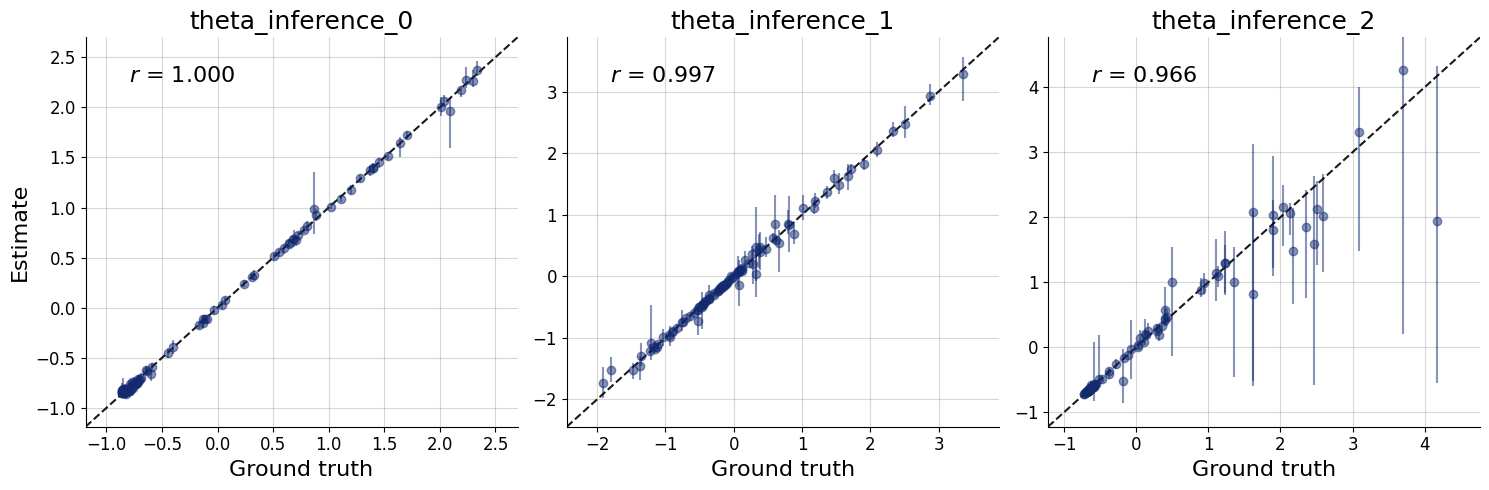

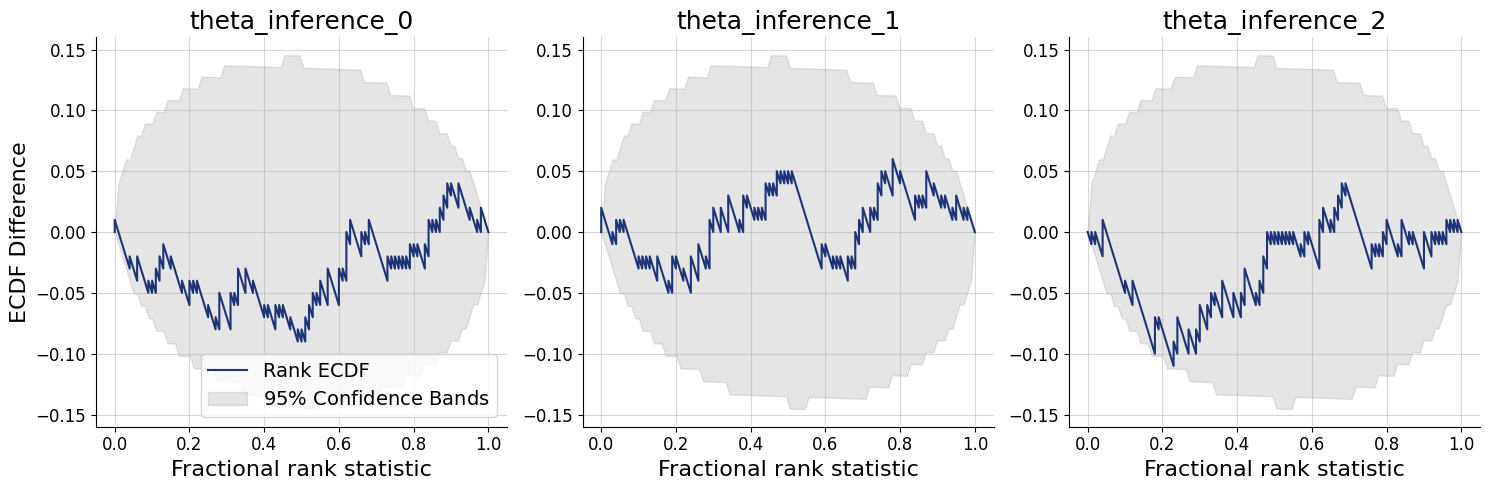

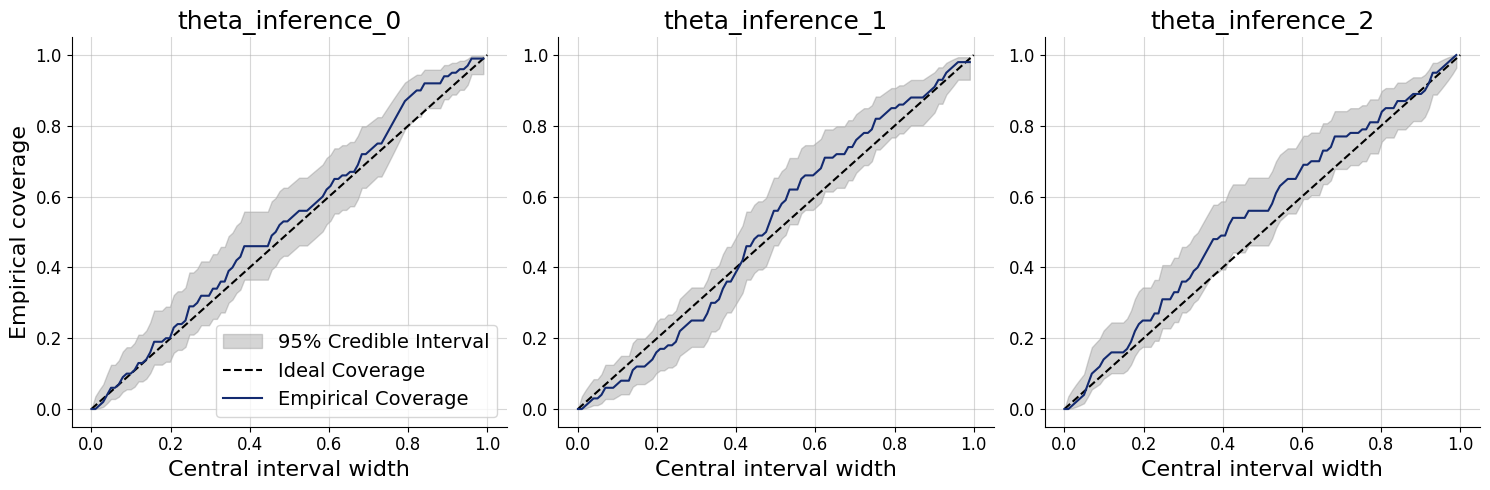

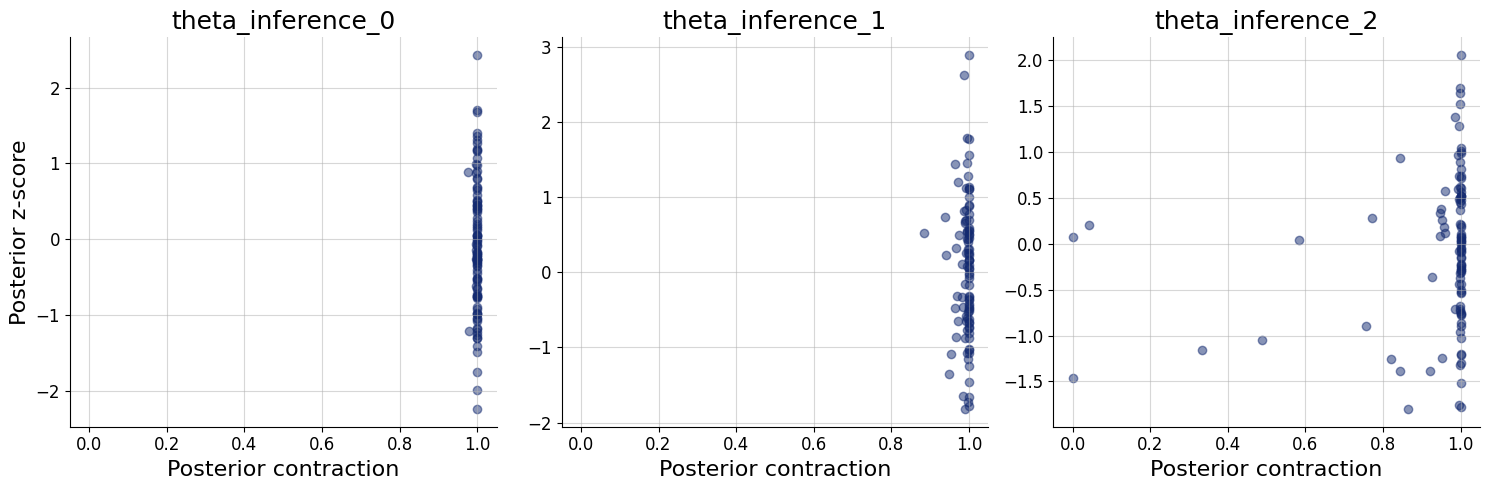

In [ ]:
# randomly pick 100 examples from the test set
num_samples = 100
idx = np.random.choice(len(test_dict["x"]), size=num_samples, replace=False)
test_dict_small = {"x": test_dict["x"][idx], "theta_condition": test_dict["theta_condition"][idx], "theta_inference": test_dict["theta_inference"][idx]}

test_data = workflow.adapter(test_dict_small)
test_data["theta_inference"] = test_data["inference_variables"]
# (test_data["x"], test_data["theta_condition"]) = test_data["inference_conditions"]


figs = workflow.plot_default_diagnostics(
    test_data=test_data,
    num_samples=100,
    approximator_kwargs={"batch_size": 16},   # try 64/32/16/8
)
for fig in figs.values():
    fig.show()